In [11]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [302]:
import os
import operator
from collections import defaultdict
import tskit
import numpy as np
import pyslim
import matplotlib.pyplot as plt

from bprime.tree_utils import load_recrates, load_neutregions
from bprime.models import BGSModel 
from bprime.utils import load_bed_annotation, load_seqlens, RecMap, midpoint, arg_nearest

In [61]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


### bgspy B maps

In [261]:
annot = load_bed_annotation(f"../data/annotation/conserved_by_chrom/conserved_chr10.bed")
seqlens = load_seqlens("../data/annotation/hg38_seqlens.tsv")
recmap = RecMap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt", seqlens=seqlens, conversion_factor=1e-8)

m = BGSModel(recmap, annot,
             seqlens={'chr10': seqlens['chr10']}, 
             w_grid=np.array([1e-7, 5e-7, 1e-8, 1e-9]),
             t_grid=np.array([0.1, 0.01, 0.001, 0.0001]))

pkl_b_file = '../data/bmaps/bgspy/B_chr10.pkl'
if os.path.exists(pkl_b_file):
    m.load_B(pkl_b_file)
else:
    m.calc_B(step=1_000, ncores=50, nchunks=100)
    m.save_B(pkl_b_file)

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.
pre-computing segment contributions...	done.


/home/vsb/projects/bprime/notebooks/../bprime/utils.py:399: UserWarning: some positions [133798000] are greater than sequence length (133797422
  return {chrom: x.rate[-1] for chrom, x in self.cumm_rates.items()}


Genome divided into 100 chunks to be processed on 50 CPUs...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:51<00:00,  2.31s/it]


### Simulation Results

In [295]:
DATADIR = '../data/slim_sims/bgsmap/'
tree_files = [os.path.join(DATADIR, f) for f in os.listdir(DATADIR) if f.endswith('.tree')]

In [296]:
len(tree_files)

500

In [297]:
def get_b(file, params, recrate=1e-8, seed=None):
    "Recapitate trees and calc B"
    ts = pyslim.load(file)
    md = ts.metadata['SLiM']['user_metadata']
    region_length = md['region_length'][0]
    N = md['N'][0]
    #recmap = load_recrates('../data/annotation/rec_100kb_chr10.bed', ts.sequence_length)
    rts = pyslim.recapitate(ts, recombination_rate=recrate, sequence_length=ts.sequence_length,
                            ancestral_Ne=N, random_seed=seed)
    length = int(ts.sequence_length)
    neut_positions = np.linspace(0, length, length // 1000).astype(int)
    params = {k: md[k][0] for k in params}
    return tuple(params.items()), neut_positions, rts.diversity(mode='branch', windows=neut_positions) / (4*N)



In [298]:
get_b(tree_files[0], ('s', 'mu'))

((('s', 0.0002), ('mu', 1e-08)),
 array([        0,      1000,      2000, ..., 129997999, 129998999,
        130000000]),
 array([1.24843136, 1.24726261, 1.24726261, ..., 0.98173282, 0.98173282,
        0.98173282]))

In [299]:
results = defaultdict(list)

for file in tree_files:
    params, pos, b = get_b(file, ('s', 'mu'))
    results[params].append((pos, b))

for key, res in results.items():
    pos = list(map(operator.itemgetter(0), res))
    b = list(map(operator.itemgetter(1), res))
    results[key] = np.stack(pos)[0, :], np.stack(b).T

Text(0, 0.5, 'B')

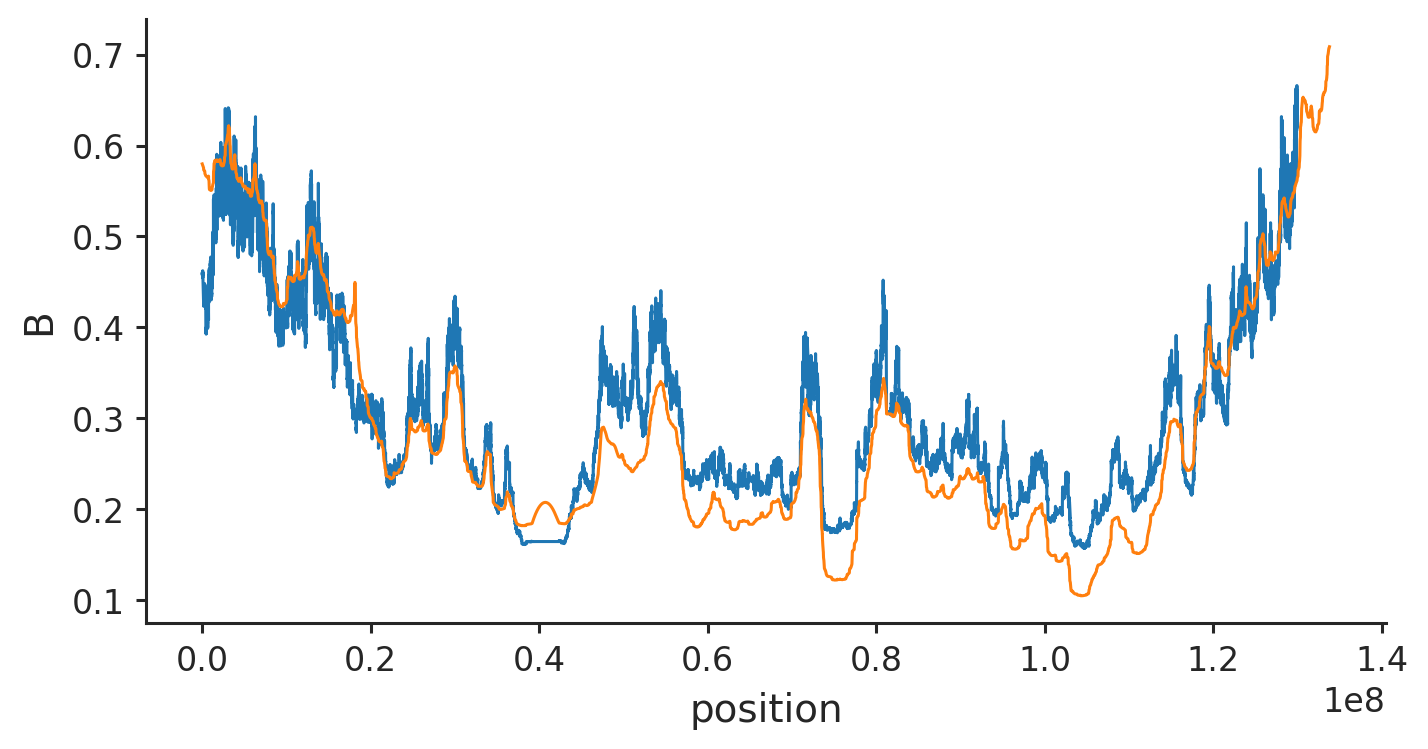

In [313]:
s, mu = 0.02, 1e-8
pos, b = results[(('s', s), ('mu', mu))]

fig, ax = plt.subplots()
ax.plot(midpoint(pos), b.mean(axis=1))
ax.plot(m.BScores.pos['chr10'], 
        np.exp(0.5*m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]))
ax.set_xlabel('position')
ax.set_ylabel('B')

In [280]:
results.keys()

dict_keys([(('s', 0.0002), ('mu', 1e-08)), (('s', 0.02), ('mu', 1e-08)), (('s', 2e-05), ('mu', 1e-08)), (('s', 0.002), ('mu', 1e-08))])

Text(0, 0.5, 'B')

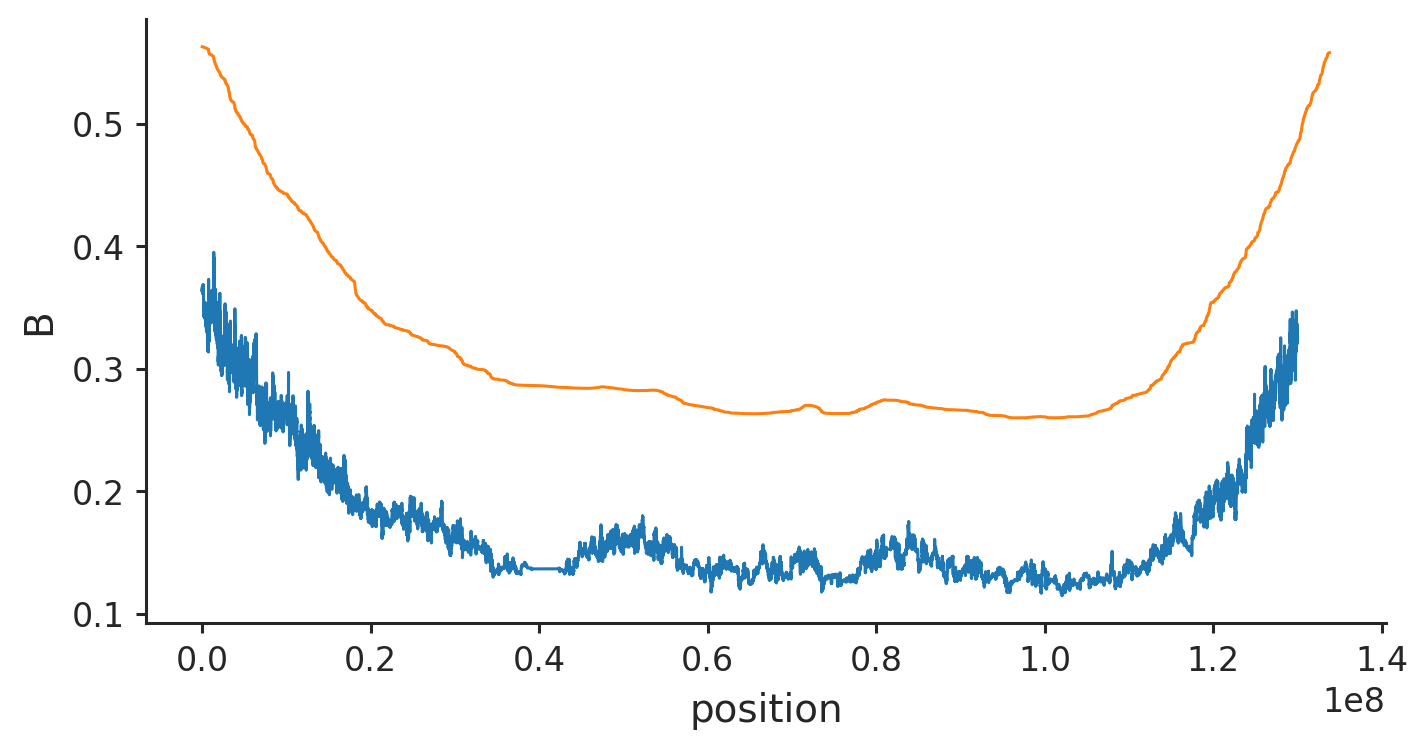

In [316]:
s, mu = 0.2, 1e-8
pos, b = results[(('s', s), ('mu', mu))]

fig, ax = plt.subplots()
ax.plot(midpoint(pos), b.mean(axis=1))
ax.plot(m.BScores.pos['chr10'], 
        np.exp(0.5*m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]))
ax.set_xlabel('position')
ax.set_ylabel('B')